<a href="https://colab.research.google.com/github/hingma/cs182fa25_public/blob/main/hw07/code/q_rnn_last_name.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN for Last Name Classification

Welcome to this assignment where you will train a neural network to predict the probable language of origin for a given last name / family name in Latin alphabets.

Throughout this task, you will gain expertise in the following areas:

- Preprocessing raw text data for suitable input into an RNN and (Optionally) LSTM.
- Utilizing PyTorch to train your recurrent neural network models.
- Evaluating your model's performance and making predictions on unseen data.

LSTM is out-of-scope this semester and will not be covered in the exams.


## Download Data

In [1]:
import os

if not os.path.exists("data"):
    # Using curl instead of wget (which isn't installed by default on macOS)
    !curl -O https://download.pytorch.org/tutorial/data.zip
    !unzip data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2814k  100 2814k    0     0  14.5M      0 --:--:-- --:--:-- --:--:-- 14.6M
Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating

## Library imports

Before starting, make sure you have all these libraries.

In [2]:
root_folder = ""
import os
import sys
import inspect
sys.path.append(root_folder)
from collections import Counter
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

import random
import numpy as np
import json

import matplotlib.pyplot as plt
# from utils import validate_to_array

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import IPython
from ipywidgets import interactive, widgets, Layout
from IPython.display import display, HTML

## Implement the Neural Network

The main objective of this task is to predict the probability of a given class given a last name, represented as

$$ \Pr ( y | x_1, x_2, x_3, ..., x_i),$$

where $y$ is the category label and each $x_i$ is a character in the last name. Building a basic character-level NLP model has the advantage of understanding how the preprocessing works at a granular level. The character-level network reads words as a sequence of characters, producing a prediction and "hidden state" at each step by feeding its previous hidden state into the next step. The final prediction corresponds to the class to which the word belongs.

All models in PyTorch inherit from the nn.Module subclass. In this assignment, you will **implement a custom model named `RecurrentClassifier`** that runs either [nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) or [nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) and define its forward function. The implementation of LSTMs is *optional*.

The forward pass of the model can be visualized with the following diagram:

```
[Embedding] -> [RNN Stack] -> [Extract Last Position] -> [Classifier]
```

- **Embedding:** This component maps each input word (integer) to a vector of real numbers.
    - Input: `[batch_size, seq_len]`
    - Output: `[batch_size, seq_len, rnn_size]`
- **RNN Stack:** This component consists of one or more RNN layers, which process the input sequence of vectors from the Embedding component.
    - Input: `[batch_size, seq_len, rnn_size]`
    - Output: `[batch_size, seq_len, rnn_size]`
- **Extract Last Position:** The RNN Stack component returns a sequence of vectors for each input example. However, for classification purposes, we only need a single vector that captures the full information of the input example. Since the RNN is left-to-right by default, the output state vector at the last position contains the full information of the input example. Therefore, for the $i$-th input example, we extract the output state vector at the last *non-pad* position, which is indicated by `last_pos[i]`.
    - Input: `[batch_size, seq_len, rnn_size]`
    - Output: `[batch_size, rnn_size]`
- **Classifier:** This component is a fully-connected layer that maps the output vectors extracted in the previous step to logits (scores before softmax), which can be used to make predictions about the language of origin for each input example.
    - Input: `[batch_size, rnn_size]`
    - Output: `[batch_size, n_categories]`


These documents would be helpful in this part:

- https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
- https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
- https://pytorch.org/docs/stable/generated/torch.gather.html
- https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html
- https://pytorch.org/docs/stable/generated/torch.Tensor.view.html

In [3]:
class RecurrentClassifier(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        rnn_size: int,
        n_categories: int,
        num_layers: int = 1,
        dropout: float = 0.0,
        model_type: str = 'lstm'
    ):
        super().__init__()
        self.rnn_size = rnn_size
        self.model_type = model_type

        ########################################################################
        # TODO: Create an embedding layer of shape [vocab_size, rnn_size]
        #
        # Hint: Use nn.Embedding
        # https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
        # It will map each word into a vector of shape [rnn_size]
        ########################################################################
        self.embedding = nn.Embedding(vocab_size, rnn_size)
        ########################################################################

        ########################################################################
        # TODO: Create a RNN stack with `num_layers` layers with tanh
        #       nonlinearity. Between each layers, there is a dropout of
        #       `dropout`. Implement it with a *single* call to `torch.nn` APIs
        #
        # Hint: See documentations at
        # https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        # Set the arguments to call `nn.RNN` such that:
        # - The shape of the input is [batch_size, seq_len, rnn_size]
        # - The shape of the output should be [batch_size, seq_len, rnn_size]
        # Make sure that the dimension ordering is correct. One of the argument
        #   in the constructor of `nn.RNN` (or `nn.LSTM`) is helpful here
        #
        # Optional: Implement one LSTM layer when `model_type` is `lstm`
        ########################################################################
        if model_type == 'lstm':
            self.lstm = nn.LSTM(
                input_size=rnn_size,
                hidden_size=rnn_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        else:
            self.rnn = nn.RNN(
                input_size=rnn_size,
                hidden_size=rnn_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                nonlinearity='tanh',
                batch_first=True
            )
        ########################################################################

        ########################################################################
        # TODO: Implement one dropout layer and the fully-connected classifier
        #       layer
        #
        # Hint: We add a dropout layer because neither nn.RNN nor nn.LSTM
        #   implements dropout after the last layer in the stack.
        # Since the input to the classifier is the output of the last position
        #   of the RNN's final layer, it has a shape of [batch_size, rnn_size].
        # The expected output should be logits, which correspond to scores
        #   before applying softmax, and should have a shape of
        #   [batch_size, n_categories].
        ########################################################################
        self.drop = nn.Dropout(dropout)
        self.output = nn.Linear(rnn_size, n_categories)
        ########################################################################

    def forward(self, x: torch.Tensor, last_pos: torch.Tensor) -> torch.Tensor:
        """
        x: integer tensor of shape [batch_size, seq_len]
        last_pos: integer tensor of shape [batch_size]

        The input tensor `x` is composed of a batch of sequences, where each
        sequence contains indices corresponding to characters. As sequences
        within the same batch may have different lengths, shorter sequences are
        padded on the right side to match the maximum sequence length of the
        batch, which is represented by `seq_len`.

        Additionally, the `last_pos` tensor records the position of the last
        character in each sequence. For instance, the first sequence in the
        batch can be represented as `[x[0, 0], x[0, 1], ..., x[0, last_pos[0]]`.
        `last_pos` is useful when extracting the output state associated with
        each sequence from the RNNs.
        """
        embeds = self.embedding(x)
        if self.model_type == 'lstm':
            rnn_out, _ = self.lstm(embeds)
        else:
            rnn_out, _ = self.rnn(embeds)

        ########################################################################
        # TODO: Retrieve the output state associated with each sequence
        #
        # Hints:
        # - The output state of all positions is returned by the RNN stack,
        #   but we only need the state in the last position for classification
        #   - The shape of `rnn_out` is [batch_size, seq_len, rnn_size]
        #   - The expected shape of `out` is [batch_size, rnn_size]
        # - For the i-th sequence, we have out[i] == rnn_out[i, last_pos[i]]
        # - Try to condense your code into a single line, without using any
        #   loops. However, if you find it too challenging to do so, you may use
        #   a single layer of for-loop.
        ########################################################################
        batch_size = rnn_out.size(0)
        out = rnn_out[torch.arange(batch_size), last_pos, :]
        ########################################################################

        out = self.drop(out)
        logits = self.output(out)
        return logits


After completing your implementation, ensure that it passes the following tests. If your implementation fails some tests, but you believe that your implementation is correct, please post the error message along with a brief description on Ed. Please refrain from posting your actual code on Ed.

In [4]:
seed = 227
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
model = RecurrentClassifier(11, 13, 17, 2, 0.1, 'rnn')

In [5]:
assert list(model.state_dict().keys()) == ['embedding.weight',
 'rnn.weight_ih_l0', # "weight input-hidden"
 'rnn.weight_hh_l0',
 'rnn.bias_ih_l0',
 'rnn.bias_hh_l0',
 'rnn.weight_ih_l1',
 'rnn.weight_hh_l1',
 'rnn.bias_ih_l1',
 'rnn.bias_hh_l1',
 'output.weight',
 'output.bias']
assert model.embedding.weight.shape == torch.Size([11, 13])
assert (
    model.rnn.weight_ih_l0.shape
    == model.rnn.weight_hh_l0.shape
    == model.rnn.weight_ih_l1.shape
    == model.rnn.weight_hh_l1.shape
    == torch.Size([13, 13])
)
assert (
    model.rnn.bias_ih_l0.shape
    == model.rnn.bias_hh_l0.shape
    == model.rnn.bias_ih_l1.shape
    == model.rnn.bias_hh_l1.shape
    == torch.Size([13])
)
assert model.output.weight.shape == torch.Size([17, 13])
assert model.output.bias.shape == torch.Size([17])

## Preprocess the dataset

The [dataset](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) contains a few thousand surnames from 18 languages of origin. Included in the data/names directory are 18 text files named as "[Language].txt". Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We'll end up with a dictionary of lists of names per language, {language: [names ...]}.




In [6]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

assert findFiles('data/names/*.txt'), "Data not found!"

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print("The normalized form of", 'Ślusàrski', "is", unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

The normalized form of Ślusàrski is Slusarski


In [7]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [8]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

**Implement the function to encode a letter to an integer:**

In [9]:
def letterToIndex(letter):
    ############################################################################
    # TODO: implement the function to map a letter (a character) into its index
    #       in `all_letters`
    #
    # e.g. letterToIndex("a") == 0
    # Don't worry about efficiency here
    ############################################################################
    return all_letters.index(letter)
    ############################################################################


assert letterToIndex("a") == 0
assert letterToIndex("'") == 56

In [10]:
# For labels, we must have numbers instead of a string. These dictionaries convert
# between these two ways of representing the labels.
num_to_cat = dict(enumerate(category_lines.keys()))
cat_to_num = dict((v,k) for k,v in num_to_cat.items())

pad = 57 # this is the next available character
vocab_size = 58 # number of characters used in total

In [11]:
def build_data():
  '''
  category_lines: a dictionary of lists of names per language, {language: [names ...]}.

  We want to translate our dictionary into a dataset that has one entry per name.
  Each datapoint is a 3-tuple consisting of:
  - x: a length-19 array with each character in the name as an element,
   padded with zeros at the end if the name is less than 19 characters.
  - y: the numerical representation of the language the name corresponds to.
  - index: the index of the last non-pad token
  '''
  data = []
  for cat in category_lines:
    for name in category_lines[cat]:
      token = np.ones(19, dtype=np.int64) * pad
      numerized = np.array([letterToIndex(l) for l in name])
      n = len(numerized)
      token[:n] = numerized
      data.append((token, cat_to_num[cat], n-1))
  return data

In [12]:
data = build_data()
seed = 227
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
random.shuffle(data)

In [13]:
n_train = int(len(data) * 0.8)
train_data = data[:n_train]
test_data = data[n_train:]

In [14]:
len(train_data)

16059

In [15]:
train_data[0]

(array([32,  8, 11, 11, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57, 57]),
 7,
 3)

In [16]:
len(test_data)

4015

In [17]:
test_data[0]

(array([50,  0, 18, 20,  3,  0, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57, 57]),
 5,
 5)

# Train the model

Training will be faster if you use the Colab GPU. If it's not already enabled, do so with Runtime -> Change runtime type.

In [18]:
def build_batch(dataset, indices):
    '''
    Helper function for creating a batch during training. Builds a batch
    of source and target elements from the dataset. See the next cell for
    when and how it's used.

    Arguments:
        dataset: List[db_element] -- A list of dataset elements
        indices: List[int] -- A list of indices of the dataset to sample
    Returns:
        batch_input: List[List[int]] -- List of tensorized names
        batch_target: List[int] -- List of numerical categories
        batch_indices: List[int] -- List of starting indices of padding
    '''
    # Recover what the entries for the batch are
    batch = [dataset[i] for i in indices]
    batch_input = np.array(list(zip(*batch))[0])
    batch_target = np.array(list(zip(*batch))[1])
    batch_indices = np.array(list(zip(*batch))[2])
    return batch_input, batch_target, batch_indices # lines, categories

In [19]:
build_batch(train_data, [1, 2, 3])

(array([[35,  0, 12,  8, 13, 18, 10, 24, 57, 57, 57, 57, 57, 57, 57, 57,
         57, 57, 57],
        [31, 11,  0, 13,  3,  4, 17, 18, 57, 57, 57, 57, 57, 57, 57, 57,
         57, 57, 57],
        [40, 20, 17, 18, 11,  4, 17, 57, 57, 57, 57, 57, 57, 57, 57, 57,
         57, 57, 57]]),
 array([0, 7, 4]),
 array([7, 7, 6]))

**Adjust the hyperparameters listed below** to train an RNN with a minimum evaluation accuracy of 80% after 20 epochs.

In [20]:
criterion = nn.CrossEntropyLoss()

# The build_batch function outputs numpy, but our model is built in pytorch,
# so we need to convert numpy to pytorch with the correct types.
batch_to_torch = lambda b_in,b_target,b_mask: (torch.tensor(b_in).long(),
                                               torch.tensor(b_target).long(),
                                               torch.tensor(b_mask).long())

############################################################################
# TODO: Tune these hyperparameters for a better performance
############################################################################
# Set hyperparameters
hidden_size = 128      # Size of the hidden layer
num_layers = 2         # Number of RNN layers
dropout = 0.3          # Dropout rate
optimizer_class = optim.Adam  # Optimizer
lr = 0.001            # Learning rate
batch_size = 64       # Batch size
############################################################################

# Do not change the number of epochs
epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("You are using", device, "for training")
list_to_device = lambda th_obj: [tensor.to(device) for tensor in th_obj]

You are using cuda for training


In [ ]:
# Optional
# lstm_model = RecurrentClassifier(vocab_size=vocab_size, rnn_size=hidden_size, n_categories=n_categories, num_layers=num_layers, dropout=dropout, model_type='lstm')
# lstm_optimizer = optimizer_class(lstm_model.parameters(), lr=lr)

In [21]:
seed = 1998
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rnn_model = RecurrentClassifier(vocab_size=vocab_size, rnn_size=hidden_size, n_categories=n_categories, num_layers=num_layers, dropout=dropout, model_type='rnn')
rnn_optimizer = optimizer_class(rnn_model.parameters(), lr=lr)

In [22]:
def train(model, optimizer, criterion, epochs, batch_size, seed):
    model.to(device)
    model.train()
    train_losses = []
    train_accuracies = []
    eval_accuracies = []
    for epoch in range(epochs):
        random.seed(seed + epoch)
        np.random.seed(seed + epoch)
        torch.manual_seed(seed + epoch)
        indices = np.random.permutation(range(len(train_data)))
        n_correct, n_total = 0, 0
        progress_bar = tqdm(range(0, (len(train_data) // batch_size) + 1))
        for i in progress_bar:
            batch = build_batch(train_data, indices[i*batch_size:(i+1)*batch_size])
            (batch_input, batch_target, batch_indices) = batch_to_torch(*batch)
            (batch_input, batch_target, batch_indices) = list_to_device((batch_input, batch_target, batch_indices))

            logits = model(batch_input, batch_indices)
            loss = criterion(logits, batch_target)
            train_losses.append(loss.item())

            predictions = logits.argmax(dim=-1)
            n_correct += (predictions == batch_target).sum().item()
            n_total += batch_target.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 10 == 0:
                progress_bar.set_description(f"Epoch: {epoch}  Iteration: {i}  Loss: {np.mean(train_losses[-10:])}")
        train_accuracies.append(n_correct / n_total * 100)
        print(f"Epoch: {epoch}  Train Accuracy: {n_correct / n_total * 100}")

        with torch.no_grad():
            indices = list(range(len(test_data)))
            n_correct, n_total = 0, 0
            for i in range(0, (len(test_data) // batch_size) + 1):
                batch = build_batch(test_data, indices[i*batch_size:(i+1)*batch_size])
                (batch_input, batch_target, batch_indices) = batch_to_torch(*batch)
                (batch_input, batch_target, batch_indices) = list_to_device((batch_input, batch_target, batch_indices))

                logits = model(batch_input, batch_indices)
                predictions = logits.argmax(dim=-1)
                n_correct += (predictions == batch_target).sum().item()
                n_total += batch_target.size(0)
            eval_accuracies.append(n_correct / n_total * 100)
            print(f"Epoch: {epoch}  Eval Accuracy: {n_correct / n_total * 100}")

    to_save = {
        "history": {
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "eval_accuracies": eval_accuracies,
        },
        "hparams": {
            "hidden_size": hidden_size,
            "num_layers": num_layers,
            "dropout": dropout,
            "optimizer_class": optimizer_class.__name__,
            "lr": lr,
            "batch_size": batch_size,
            "epochs": epochs,
            "seed": seed
        },
        "model": [
            (name, list(param.shape))
            for name, param in rnn_model.named_parameters()
        ]
    }
    return to_save

In [23]:
rnn_log = train(rnn_model, rnn_optimizer, criterion, epochs, batch_size, 1997)

Epoch: 0  Iteration: 249  Loss: 0.9620617389678955: 100%|██████████| 251/251 [00:02<00:00, 105.40it/s]


Epoch: 0  Train Accuracy: 64.4996575129211
Epoch: 0  Eval Accuracy: 72.55292652552926


Epoch: 1  Iteration: 249  Loss: 0.7928646624088287: 100%|██████████| 251/251 [00:00<00:00, 337.01it/s]


Epoch: 1  Train Accuracy: 73.80285198331154
Epoch: 1  Eval Accuracy: 76.31382316313822


Epoch: 2  Iteration: 249  Loss: 0.7792674720287323: 100%|██████████| 251/251 [00:00<00:00, 347.62it/s]


Epoch: 2  Train Accuracy: 77.34603649044149
Epoch: 2  Eval Accuracy: 77.45952677459526


Epoch: 3  Iteration: 249  Loss: 0.6789080202579498: 100%|██████████| 251/251 [00:00<00:00, 328.44it/s]


Epoch: 3  Train Accuracy: 79.40718600161904
Epoch: 3  Eval Accuracy: 80.0


Epoch: 4  Iteration: 249  Loss: 0.6891693651676178: 100%|██████████| 251/251 [00:00<00:00, 262.08it/s]


Epoch: 4  Train Accuracy: 80.45955538950122
Epoch: 4  Eval Accuracy: 80.84682440846824


Epoch: 5  Iteration: 249  Loss: 0.5511182904243469: 100%|██████████| 251/251 [00:01<00:00, 250.01it/s]


Epoch: 5  Train Accuracy: 81.69873591132698
Epoch: 5  Eval Accuracy: 81.59402241594023


Epoch: 6  Iteration: 249  Loss: 0.5357785254716874: 100%|██████████| 251/251 [00:00<00:00, 331.75it/s]


Epoch: 6  Train Accuracy: 82.54561305187123
Epoch: 6  Eval Accuracy: 80.94645080946451


Epoch: 7  Iteration: 249  Loss: 0.5573830515146255: 100%|██████████| 251/251 [00:00<00:00, 277.80it/s]


Epoch: 7  Train Accuracy: 83.39249019241547
Epoch: 7  Eval Accuracy: 81.69364881693649


Epoch: 8  Iteration: 249  Loss: 0.5119010299444199: 100%|██████████| 251/251 [00:00<00:00, 272.46it/s]


Epoch: 8  Train Accuracy: 84.1708699171804
Epoch: 8  Eval Accuracy: 82.04234122042341


Epoch: 9  Iteration: 249  Loss: 0.5188688725233078: 100%|██████████| 251/251 [00:00<00:00, 293.85it/s]


Epoch: 9  Train Accuracy: 84.44485958029765
Epoch: 9  Eval Accuracy: 81.69364881693649


Epoch: 10  Iteration: 249  Loss: 0.49621556997299193: 100%|██████████| 251/251 [00:00<00:00, 346.39it/s]


Epoch: 10  Train Accuracy: 85.12360670029267
Epoch: 10  Eval Accuracy: 81.99252801992529


Epoch: 11  Iteration: 249  Loss: 0.49487788826227186: 100%|██████████| 251/251 [00:00<00:00, 336.55it/s]


Epoch: 11  Train Accuracy: 85.53459119496856
Epoch: 11  Eval Accuracy: 82.1917808219178


Epoch: 12  Iteration: 249  Loss: 0.45237680375576017: 100%|██████████| 251/251 [00:00<00:00, 297.04it/s]


Epoch: 12  Train Accuracy: 85.81480789588393
Epoch: 12  Eval Accuracy: 81.94271481942715


Epoch: 13  Iteration: 249  Loss: 0.44039020538330076: 100%|██████████| 251/251 [00:00<00:00, 263.32it/s]


Epoch: 13  Train Accuracy: 86.77999875459244
Epoch: 13  Eval Accuracy: 81.66874221668742


Epoch: 14  Iteration: 249  Loss: 0.4230612128973007: 100%|██████████| 251/251 [00:00<00:00, 332.40it/s]


Epoch: 14  Train Accuracy: 86.98549100193038
Epoch: 14  Eval Accuracy: 82.54047322540472


Epoch: 15  Iteration: 249  Loss: 0.39641531705856325: 100%|██████████| 251/251 [00:00<00:00, 337.10it/s]


Epoch: 15  Train Accuracy: 87.15984806027772
Epoch: 15  Eval Accuracy: 81.61892901618928


Epoch: 16  Iteration: 249  Loss: 0.41929000318050386: 100%|██████████| 251/251 [00:00<00:00, 335.20it/s]


Epoch: 16  Train Accuracy: 87.67669219752165
Epoch: 16  Eval Accuracy: 82.29140722291407


Epoch: 17  Iteration: 249  Loss: 0.3679748922586441: 100%|██████████| 251/251 [00:00<00:00, 337.92it/s]


Epoch: 17  Train Accuracy: 87.5708325549536
Epoch: 17  Eval Accuracy: 83.56164383561644


Epoch: 18  Iteration: 249  Loss: 0.45990122854709625: 100%|██████████| 251/251 [00:00<00:00, 333.11it/s]


Epoch: 18  Train Accuracy: 88.00672520082196
Epoch: 18  Eval Accuracy: 82.34122042341221


Epoch: 19  Iteration: 249  Loss: 0.36360118836164473: 100%|██████████| 251/251 [00:00<00:00, 329.09it/s]


Epoch: 19  Train Accuracy: 88.0814496543994
Epoch: 19  Eval Accuracy: 82.31631382316313


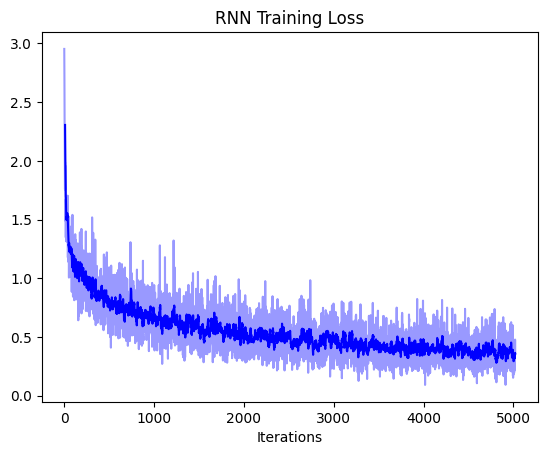

In [24]:
n_steps = len(rnn_log["history"]["train_losses"])
plt.plot(range(n_steps), rnn_log["history"]["train_losses"], alpha=0.4, color="blue")
moving_avg = np.convolve(np.array(rnn_log["history"]["train_losses"]), np.ones(10), 'valid') / 10
plt.plot(range(9, n_steps), moving_avg.tolist(), color="blue")
plt.xlabel("Iterations")
plt.title("RNN Training Loss")
plt.show()

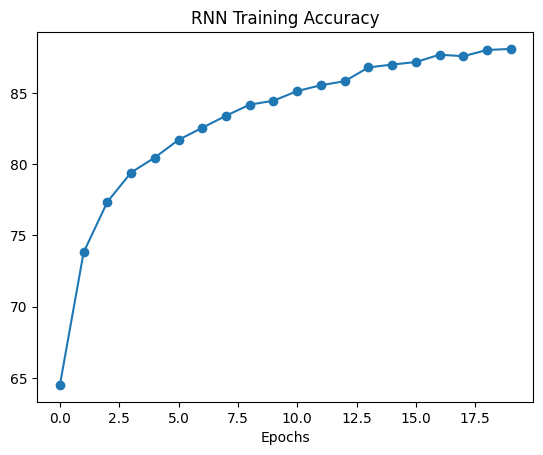

In [25]:
plt.plot(rnn_log["history"]["train_accuracies"], marker='o')
plt.xlabel("Epochs")
plt.title("RNN Training Accuracy")
plt.show()

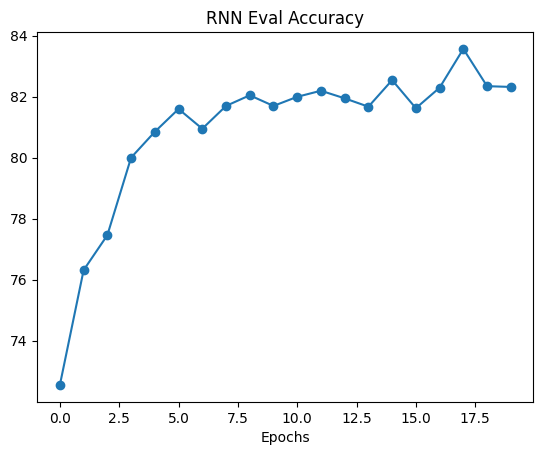

In [26]:
plt.plot(rnn_log["history"]["eval_accuracies"], marker='o')
plt.xlabel("Epochs")
plt.title("RNN Eval Accuracy")
plt.show()

In [ ]:
# Optional
# train(lstm_model, lstm_optimizer, criterion, epochs, batch_size, 1997)

## Use Your RNN: Try Your Own Name

Attempt to use the code cells below to **predict the origin of your own last name**.

In [27]:
def classify_name(name, model):
    '''
    Numerize the name and return the most likely number representation of the
    predicted class.
    '''
    # change this if your last name is longer than 19 characters
    token = np.ones(19, dtype=np.int64) * pad
    numerized = np.array([letterToIndex(l) for l in name])
    n = len(numerized)
    token[:n] = numerized
    print(token)
    logits = model(
        torch.tensor(token, dtype=torch.long)[None, :],
        torch.tensor([n - 1], dtype=torch.long)
    )
    return logits.argmax(dim=-1).item()

In [28]:
model = rnn_model
model.eval()
model.cpu()
############################################################################
# TODO: Enter your last name
############################################################################
name = "Tang"
############################################################################
rnn_log["last_name"] = name
rnn_log["source_init"] = inspect.getsource(RecurrentClassifier.__init__)
rnn_log["source_forward"] = inspect.getsource(RecurrentClassifier.forward)
print("Predicting origin language for name: "+ name)
c = classify_name(name, model)
print(num_to_cat[c])

Predicting origin language for name: Tang
[45  0 13  6 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57]
Vietnamese


### Question

Although the neural network you have trained is intended to predict the language of origin for a given last name, it could potentially be misused. **In what ways do you think this could be problematic in real-world applications?** Include your answer in your submission of the written assignment.